In [1]:
import torch
import torch.utils.data
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from tqdm import tqdm
from PIL import Image, ImageOps

import torch.nn as nn
from pathlib import Path

import models.MathNet as mnt
import models.MathNet20 as mnt20
import models.MathNet112 as mnt112

In [2]:
BATCH_SIZE = 128
EPOCHS = 31
IMAGE_SIZE = 224

In [3]:
# the training transforms
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(1),
    transforms.ToTensor()
    #transforms.Normalize(std=0.5, mean=0.2)
    
])
# the validation transforms
valid_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(1),
    transforms.ToTensor()
])

In [4]:
dataset = torchvision.datasets.ImageFolder(r'T:\my_programs\Math_recognition\TRAIN\dataset_balance'+str(IMAGE_SIZE), transform=train_transform)
print(len(dataset))

131660


In [5]:
classes_dict = dataset.class_to_idx
classes = []
for key in classes_dict.keys():
    classes.append(str(key))
classes.sort()
classes

['(',
 ')',
 '+',
 '-',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '=',
 'A',
 'C',
 'F',
 'I-',
 'alpha',
 'and',
 'beta',
 'delta',
 'equal',
 'exists',
 'forall',
 'gamma',
 'lambda',
 'mu',
 'not',
 'omega',
 'or',
 'phi',
 'pi',
 'psi',
 'rightarrow',
 'sigma',
 'tau',
 'theta',
 'upsilon',
 'x',
 'y',
 'z']

In [6]:
# classes = ['(', ')', ',', '-', 
#                    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
#                    'A', '[', 'α', 'and', 'β', '∃', 'F', '∀', 
#                    'γ', 'λ', 'μ', 'ω', 'or', 'φ', '→', 
#                    'σ', 'sqrt', 'θ', 'v', 'x', 'y', 'z']

NUM_CLASSES = len(classes)

def map_pred(ind):
    if ind < NUM_CLASSES:
        return classes[ind]
    return 'ERROR MAPPIMG'

NUM_CLASSES

43

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
device

device(type='cuda', index=0)

In [8]:
def add_contrast(x, factor):
    return transforms.functional.adjust_contrast(x, factor)

In [9]:
mean, std = dataset[0][0].mean(), dataset[0][0].std()
print(mean, std)

tensor(0.9764) tensor(0.1416)


In [10]:
def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [11]:
datasets = train_val_dataset(dataset)
print(type(datasets['train']))
print(len(datasets['val']))
# The original dataset is avail


<class 'torch.utils.data.dataset.Subset'>
26332


In [12]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 131660
    Root location: T:\my_programs\Math_recognition\TRAIN\dataset_balance224
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               Grayscale(num_output_channels=1)
               ToTensor()
           )


26332
10


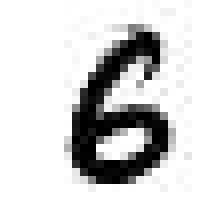

In [13]:
# training dataset
train_dataset = datasets['train']
# validation dataset
valid_dataset = (datasets['val'])
# training data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=6, pin_memory=True
)
# validation data loaders
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=6, pin_memory=True
)
# training data loaders

train_dataset
print(len(valid_dataset))
print(valid_dataset[15551][1])
#print(valid_dataset.dataset.targets)
aaa = transforms.ToPILImage()
display(aaa(valid_dataset[15551][0]))

In [14]:
from collections import Counter
#train_classes = [label for _, label in valid_dataset]
#Counter(train_classes)
train_classes = [dataset.targets[i] for i in train_dataset.indices]
valid_classes = [dataset.targets[i] for i in valid_dataset.indices]
print(Counter(train_classes))
print(Counter(valid_classes))


Counter({34: 2814, 30: 2712, 21: 2706, 29: 2682, 17: 2661, 33: 2642, 19: 2639, 35: 2624, 39: 2614, 41: 2608, 25: 2608, 23: 2607, 12: 2592, 6: 2589, 8: 2582, 2: 2576, 28: 2558, 10: 2556, 32: 2555, 0: 2541, 24: 2530, 38: 2530, 18: 2527, 13: 2526, 4: 2526, 5: 2525, 7: 2510, 26: 2507, 9: 2504, 14: 2504, 11: 2499, 1: 2497, 40: 2496, 42: 2483, 15: 2483, 16: 2478, 3: 2473, 20: 2450, 31: 2305, 22: 1507, 36: 1468, 27: 1326, 37: 1208})
Counter({34: 742, 40: 702, 41: 698, 21: 690, 33: 681, 1: 677, 38: 674, 8: 670, 25: 668, 35: 662, 5: 661, 29: 660, 3: 647, 30: 646, 4: 642, 26: 641, 16: 641, 11: 638, 31: 635, 14: 634, 0: 633, 20: 633, 17: 627, 28: 627, 12: 623, 2: 622, 9: 620, 39: 620, 19: 617, 23: 615, 24: 614, 32: 613, 13: 612, 10: 611, 7: 610, 42: 607, 15: 589, 6: 561, 18: 545, 22: 370, 36: 369, 27: 362, 37: 323})


In [15]:
d = dict(Counter(valid_dataset.dataset.targets))
print(d)

{0: 3174, 1: 3174, 2: 3198, 3: 3120, 4: 3168, 5: 3186, 6: 3150, 7: 3120, 8: 3252, 9: 3124, 10: 3167, 11: 3137, 12: 3215, 13: 3138, 14: 3138, 15: 3072, 16: 3119, 17: 3288, 18: 3072, 19: 3256, 20: 3083, 21: 3396, 22: 1877, 23: 3222, 24: 3144, 25: 3276, 26: 3148, 27: 1688, 28: 3185, 29: 3342, 30: 3358, 31: 2940, 32: 3168, 33: 3323, 34: 3556, 35: 3286, 36: 1837, 37: 1531, 38: 3204, 39: 3234, 40: 3198, 41: 3306, 42: 3090}


<Axes: ylabel='Сharactrs'>

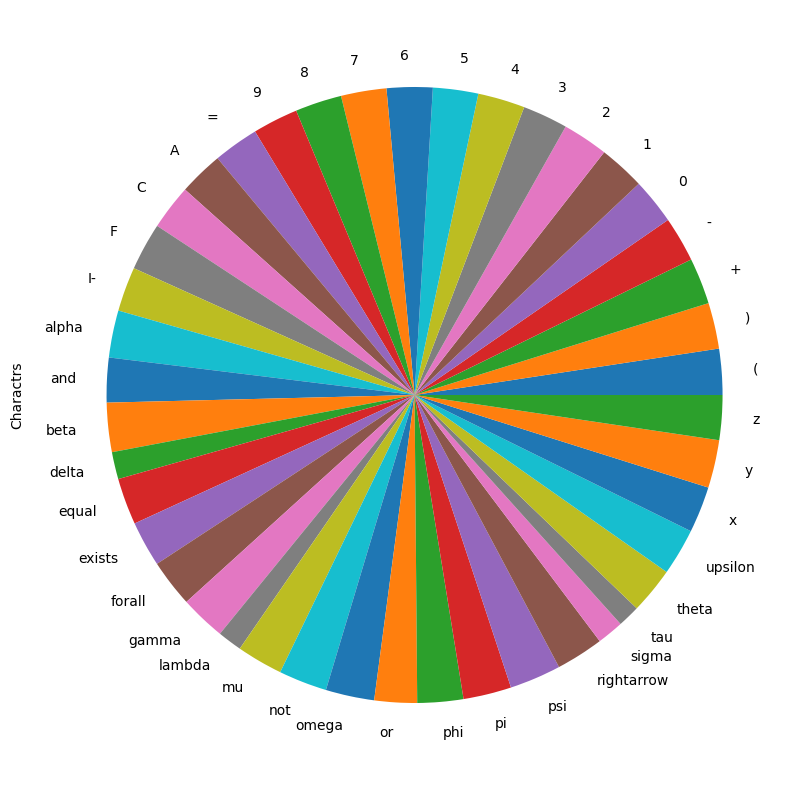

In [16]:
import pandas as pd
df = pd.Series(data=d,name='Сharactrs')    
df.plot(labels=classes,kind='pie',figsize=(10,10))

In [17]:
# training
def train(model, trainloader, optimizer, loss_function):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=int(len(trainloader))):
        counter += 1
        optimizer.zero_grad()
        x, y = data
        x = x.to(device)      
        y = y.to(device)       
        outputs = model.forward(x)
        loss = loss_function(outputs, y)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == y).sum().item()
        loss.backward()
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [18]:
def validate(model, testloader, loss_function):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=int(len(testloader))):
            counter += 1
            x, y = data
            x = x.to(device)      
            y = y.to(device)
            # forward pass
            outputs = model(x)
            # calculate the loss
            loss = loss_function(outputs, y)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == y).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [23]:
# if (IMAGE_SIZE == 56):
#     model = mnt56.MathNet56()
# elif (IMAGE_SIZE == 224):
#     model = mnt.MathNet()

model = mnt.MathNet()

print(mnt.NUM_CLASSES)

torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
model = model.to(device)
device
type(model)

43


models.MathNet.MathNet

In [25]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)

In [26]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, label=''):
    """
    Function to save the loss and accuracy plots to disk.
    """
    Path('outputs').mkdir(parents=True, exist_ok=True)
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('outputs/mathnet'+str(IMAGE_SIZE)+'_accuracy'+label+'.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/mathnet'+str(IMAGE_SIZE)+'_loss'+label+'.png')

[INFO]: Epoch 1 of 31
Training


100%|██████████| 823/823 [02:26<00:00,  5.63it/s]


Validation


100%|██████████| 206/206 [00:12<00:00, 17.13it/s]


Training loss: 0.373, training acc: 91.431
Validation loss: 0.131, validation acc: 96.464
--------------------------------------------------
[INFO]: Epoch 2 of 31
Training


100%|██████████| 823/823 [02:22<00:00,  5.79it/s]


Validation


100%|██████████| 206/206 [00:12<00:00, 16.66it/s]


Training loss: 0.088, training acc: 97.789
Validation loss: 0.088, validation acc: 97.596
--------------------------------------------------
[INFO]: Epoch 3 of 31
Training


100%|██████████| 823/823 [02:23<00:00,  5.75it/s]


Validation


100%|██████████| 206/206 [00:12<00:00, 16.55it/s]


Training loss: 0.066, training acc: 98.314
Validation loss: 0.099, validation acc: 97.205
--------------------------------------------------
[INFO]: Epoch 4 of 31
Training


100%|██████████| 823/823 [02:23<00:00,  5.75it/s]


Validation


100%|██████████| 206/206 [00:12<00:00, 16.88it/s]


Training loss: 0.054, training acc: 98.594
Validation loss: 0.075, validation acc: 97.896
--------------------------------------------------
[INFO]: Epoch 5 of 31
Training


100%|██████████| 823/823 [02:25<00:00,  5.67it/s]


Validation


100%|██████████| 206/206 [00:13<00:00, 15.04it/s]


Training loss: 0.046, training acc: 98.771
Validation loss: 0.055, validation acc: 98.489
--------------------------------------------------
[INFO]: Epoch 6 of 31
Training


100%|██████████| 823/823 [02:27<00:00,  5.59it/s]


Validation


100%|██████████| 206/206 [00:12<00:00, 16.05it/s]


Training loss: 0.041, training acc: 98.918
Validation loss: 0.054, validation acc: 98.424
--------------------------------------------------
[INFO]: Epoch 7 of 31
Training


100%|██████████| 823/823 [02:15<00:00,  6.07it/s]


Validation


100%|██████████| 206/206 [00:12<00:00, 16.41it/s]


Training loss: 0.036, training acc: 99.045
Validation loss: 0.059, validation acc: 98.105
--------------------------------------------------
[INFO]: Epoch 8 of 31
Training


100%|██████████| 823/823 [02:14<00:00,  6.10it/s]


Validation


100%|██████████| 206/206 [00:12<00:00, 16.40it/s]


Training loss: 0.034, training acc: 99.071
Validation loss: 0.088, validation acc: 97.338
--------------------------------------------------
[INFO]: Epoch 9 of 31
Training


100%|██████████| 823/823 [02:14<00:00,  6.12it/s]


Validation


100%|██████████| 206/206 [00:12<00:00, 16.55it/s]


Training loss: 0.030, training acc: 99.184
Validation loss: 0.040, validation acc: 98.899
--------------------------------------------------
[INFO]: Epoch 10 of 31
Training


100%|██████████| 823/823 [02:14<00:00,  6.13it/s]


Validation


100%|██████████| 206/206 [00:12<00:00, 16.52it/s]


Training loss: 0.027, training acc: 99.277
Validation loss: 0.055, validation acc: 98.413
--------------------------------------------------
[INFO]: Epoch 11 of 31
Training


100%|██████████| 823/823 [02:14<00:00,  6.11it/s]


Validation


100%|██████████| 206/206 [00:12<00:00, 16.50it/s]


Training loss: 0.025, training acc: 99.341
Validation loss: 0.047, validation acc: 98.701
--------------------------------------------------
[INFO]: Epoch 12 of 31
Training


100%|██████████| 823/823 [02:14<00:00,  6.10it/s]


Validation


100%|██████████| 206/206 [00:12<00:00, 16.50it/s]


Training loss: 0.023, training acc: 99.370
Validation loss: 0.044, validation acc: 98.857
--------------------------------------------------
[INFO]: Epoch 13 of 31
Training


100%|██████████| 823/823 [02:23<00:00,  5.75it/s]


Validation


100%|██████████| 206/206 [00:13<00:00, 15.35it/s]


Training loss: 0.021, training acc: 99.416
Validation loss: 0.045, validation acc: 98.808
--------------------------------------------------
[INFO]: Epoch 14 of 31
Training


100%|██████████| 823/823 [02:20<00:00,  5.87it/s]


Validation


100%|██████████| 206/206 [00:12<00:00, 17.09it/s]


Training loss: 0.019, training acc: 99.479
Validation loss: 0.049, validation acc: 98.678
--------------------------------------------------
[INFO]: Epoch 15 of 31
Training


100%|██████████| 823/823 [02:22<00:00,  5.76it/s]


Validation


100%|██████████| 206/206 [00:12<00:00, 16.79it/s]


Training loss: 0.018, training acc: 99.481
Validation loss: 0.037, validation acc: 99.096
--------------------------------------------------
[INFO]: Epoch 16 of 31
Training


100%|██████████| 823/823 [02:23<00:00,  5.75it/s]


Validation


100%|██████████| 206/206 [00:12<00:00, 17.07it/s]


Training loss: 0.017, training acc: 99.524
Validation loss: 0.045, validation acc: 98.800
--------------------------------------------------
[INFO]: Epoch 17 of 31
Training


100%|██████████| 823/823 [02:19<00:00,  5.89it/s]


Validation


100%|██████████| 206/206 [00:13<00:00, 14.85it/s]


Training loss: 0.015, training acc: 99.595
Validation loss: 0.087, validation acc: 97.634
--------------------------------------------------
[INFO]: Epoch 18 of 31
Training


100%|██████████| 823/823 [02:29<00:00,  5.52it/s]


Validation


100%|██████████| 206/206 [00:12<00:00, 17.14it/s]


Training loss: 0.014, training acc: 99.611
Validation loss: 0.051, validation acc: 98.633
--------------------------------------------------
[INFO]: Epoch 19 of 31
Training


100%|██████████| 823/823 [02:27<00:00,  5.59it/s]


Validation


100%|██████████| 206/206 [00:12<00:00, 17.08it/s]


Training loss: 0.014, training acc: 99.588
Validation loss: 0.040, validation acc: 98.990
--------------------------------------------------
[INFO]: Epoch 20 of 31
Training


100%|██████████| 823/823 [02:32<00:00,  5.39it/s]


Validation


100%|██████████| 206/206 [00:13<00:00, 15.83it/s]


Training loss: 0.012, training acc: 99.659
Validation loss: 0.049, validation acc: 98.758
--------------------------------------------------
[INFO]: Epoch 21 of 31
Training


100%|██████████| 823/823 [02:23<00:00,  5.72it/s]


Validation


100%|██████████| 206/206 [00:14<00:00, 14.19it/s]


Training loss: 0.012, training acc: 99.687
Validation loss: 0.039, validation acc: 99.028
--------------------------------------------------
[INFO]: Epoch 22 of 31
Training


100%|██████████| 823/823 [02:39<00:00,  5.15it/s]


Validation


100%|██████████| 206/206 [00:14<00:00, 14.53it/s]


Training loss: 0.012, training acc: 99.661
Validation loss: 0.039, validation acc: 99.070
--------------------------------------------------
[INFO]: Epoch 23 of 31
Training


100%|██████████| 823/823 [02:30<00:00,  5.48it/s]


Validation


100%|██████████| 206/206 [00:13<00:00, 15.10it/s]


Training loss: 0.010, training acc: 99.732
Validation loss: 0.041, validation acc: 98.940
--------------------------------------------------
[INFO]: Epoch 24 of 31
Training


100%|██████████| 823/823 [02:30<00:00,  5.47it/s]


Validation


100%|██████████| 206/206 [00:13<00:00, 15.13it/s]


Training loss: 0.009, training acc: 99.750
Validation loss: 0.047, validation acc: 98.933
--------------------------------------------------
[INFO]: Epoch 25 of 31
Training


100%|██████████| 823/823 [02:26<00:00,  5.61it/s]


Validation


100%|██████████| 206/206 [00:11<00:00, 17.17it/s]


Training loss: 0.010, training acc: 99.737
Validation loss: 0.042, validation acc: 98.990
--------------------------------------------------
[INFO]: Epoch 26 of 31
Training


100%|██████████| 823/823 [02:18<00:00,  5.95it/s]


Validation


100%|██████████| 206/206 [00:13<00:00, 15.63it/s]


Training loss: 0.009, training acc: 99.755
Validation loss: 0.041, validation acc: 98.994
--------------------------------------------------
[INFO]: Epoch 27 of 31
Training


100%|██████████| 823/823 [02:32<00:00,  5.41it/s]


Validation


100%|██████████| 206/206 [00:13<00:00, 15.43it/s]


Training loss: 0.009, training acc: 99.743
Validation loss: 0.050, validation acc: 98.728
--------------------------------------------------
[INFO]: Epoch 28 of 31
Training


100%|██████████| 823/823 [02:35<00:00,  5.31it/s]


Validation


100%|██████████| 206/206 [00:13<00:00, 15.73it/s]


Training loss: 0.008, training acc: 99.789
Validation loss: 0.040, validation acc: 99.073
--------------------------------------------------
[INFO]: Epoch 29 of 31
Training


100%|██████████| 823/823 [02:35<00:00,  5.29it/s]


Validation


100%|██████████| 206/206 [00:13<00:00, 15.39it/s]


Training loss: 0.006, training acc: 99.848
Validation loss: 0.041, validation acc: 99.054
--------------------------------------------------
[INFO]: Epoch 30 of 31
Training


100%|██████████| 823/823 [02:31<00:00,  5.44it/s]


Validation


100%|██████████| 206/206 [00:13<00:00, 14.98it/s]


Training loss: 0.007, training acc: 99.800
Validation loss: 0.072, validation acc: 98.204
--------------------------------------------------
[INFO]: Epoch 31 of 31
Training


100%|██████████| 823/823 [02:32<00:00,  5.39it/s]


Validation


100%|██████████| 206/206 [00:13<00:00, 15.81it/s]


Training loss: 0.008, training acc: 99.789
Validation loss: 0.047, validation acc: 98.899
--------------------------------------------------
TRAINING COMPLETE


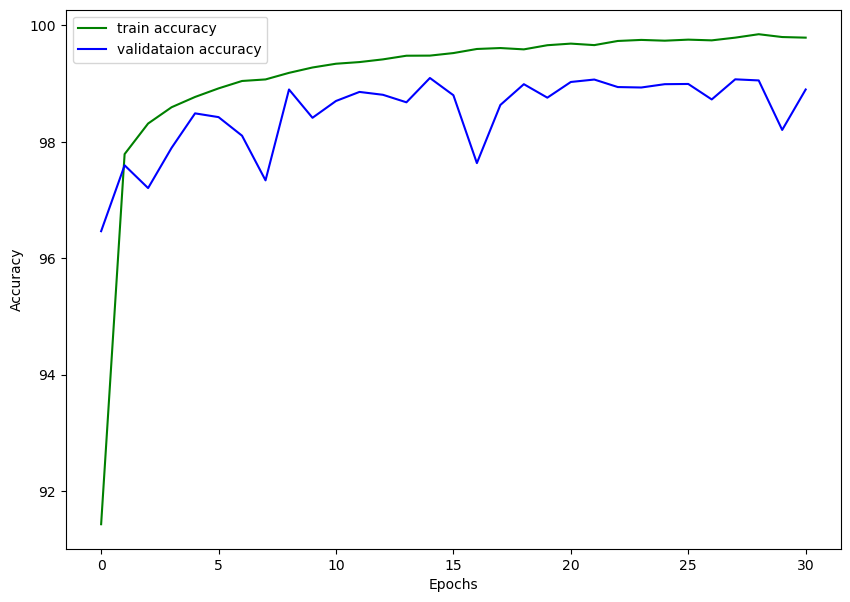

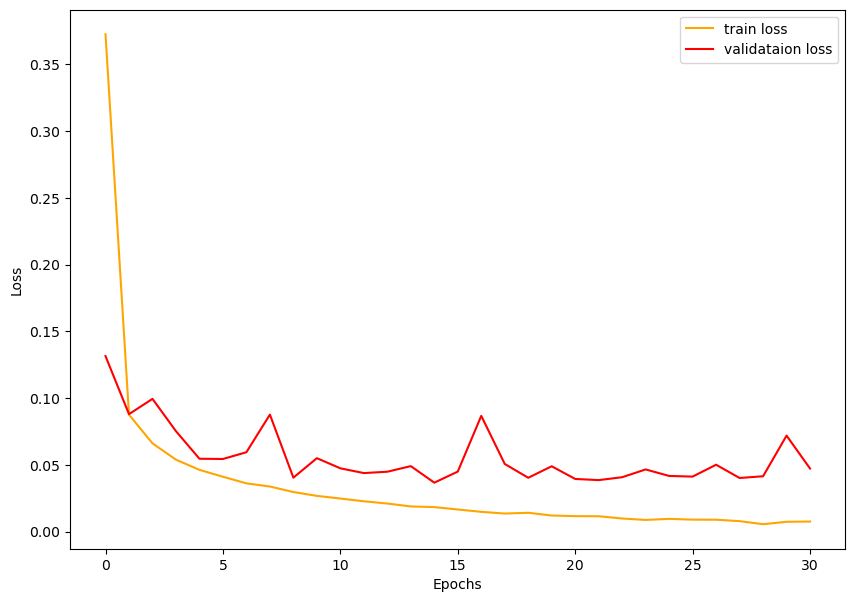

In [27]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
Path('models/mathnet'+str(IMAGE_SIZE)+'/').mkdir(parents=True, exist_ok=True)
# start the training
for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                              optimizer, loss)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                 loss)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    
    torch.save(model.state_dict(), 'models/mathnet'+str(IMAGE_SIZE)+'/mathnet'+str(epoch)+'.ml')
    
# save the trained model weights
torch.save(model.state_dict(), 'models/mathnet'+str(IMAGE_SIZE)+'/mathnet.ml')
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

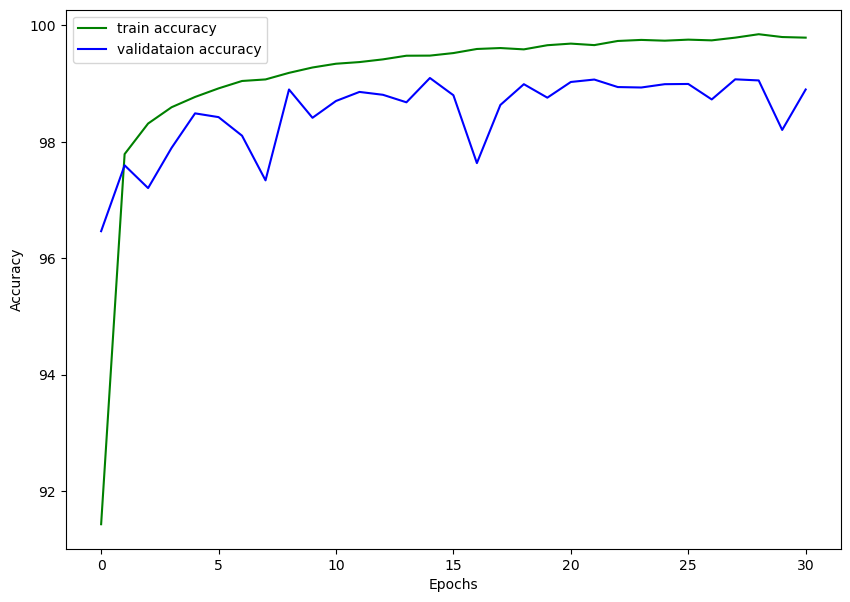

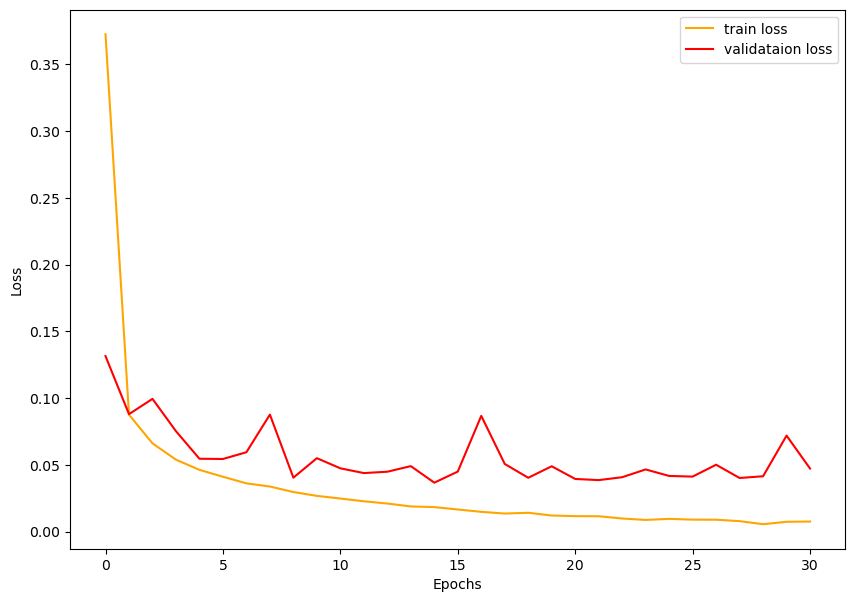

In [28]:
save_plots(train_acc, valid_acc, train_loss, valid_loss)

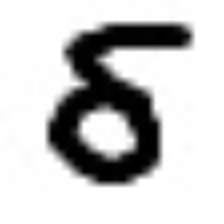

tensor([[ -82.6875,  -85.2369, -137.8062,  -97.7785,  -67.7073, -115.3184,
          -58.6521,  -70.5241, -121.2513,  -14.3327,  -44.8618, -136.4410,
          -72.2798,  -96.1201,  -83.1705,  -30.1377,  -82.5178, -104.4976,
          -78.4089,  -76.1982, -106.2394,  -87.6528,   52.9259,  -72.2265,
          -95.7787, -110.6588,  -58.5389,  -64.2257,  -27.1921,  -80.3533,
          -32.2442, -160.2320,  -52.4088, -101.4958, -127.5409,  -89.8408,
           -2.0104,  -16.4817,  -62.2290,  -57.2785, -157.4678,  -82.2879,
          -61.3839]], device='cuda:0', grad_fn=<MulBackward0>) delta


In [29]:
import cv2
from PIL import Image, ImageOps

model.eval()

img = Image.open("TEST/0.jpg")
#print(img.shape)
convert_tensor = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.Grayscale(1),
    transforms.ToTensor()

])        
x_image = convert_tensor(img)

aaa = transforms.ToPILImage()
display(aaa(x_image))

x_image = x_image.unsqueeze(0).float()
x_image = x_image.to(device)

pred = model(x_image) 
print(pred*10, map_pred(pred.argmax().item()))

In [30]:
import cv2
from PIL import Image, ImageOps

m = mnt.MathNet()
m.load_state_dict(torch.load('T:\my_programs\Math_recognition\models\mathnet224_15.03'+'/mathnet.ml'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
m = m.to(device)
m.eval()

img = Image.open("TEST/0.jpg")
#print(img.shape)
convert_tensor = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.Grayscale(1),
    transforms.ToTensor()

])        
x_image = convert_tensor(img)

aaa = transforms.ToPILImage()
display(aaa(x_image))

x_image = x_image.unsqueeze(0).float()
x_image = x_image.to(device)

pred = m(x_image) 
print(pred*10, map_pred(pred.argmax().item()))

FileNotFoundError: [Errno 2] No such file or directory: 'T:\\my_programs\\Math_recognition\\models\\mathnet224_15.03/mathnet.ml'